# WISE Global Soil Profile Data, version 3.1

[WISE - Global Soil Profile Data, version 3.1](https://data.isric.org/geonetwork/srv/eng/catalog.search#/metadata/a351682c-330a-4995-a5a1-57ad160e621c)

In [ ]:
import os, io, subprocess
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from earthshotsoil.core import *

In [ ]:
DIR_DATA = Path('../data')

Download and unpack dataset.

In [ ]:
# ! wget https://files.isric.org/public/wise/WD-WISE.zip

--2021-01-18 13:40:58--  https://files.isric.org/public/wise/WD-WISE.zip
Resolving files.isric.org (files.isric.org)... 137.224.9.5
Connecting to files.isric.org (files.isric.org)|137.224.9.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3253519 (3.1M) [application/zip]
Saving to: ‘WD-WISE.zip.1’

WD-WISE.zip.1       100%[===================>]   3.10M   206KB/s    in 17s     

2021-01-18 13:41:17 (190 KB/s) - ‘WD-WISE.zip.1’ saved [3253519/3253519]



In [ ]:
# ! unzip WD-WISE.zip

Archive:  WD-WISE.zip
   creating: ISRIC_report_2008_02/
  inflating: ISRIC_report_2008_02/ISRIC-WISE_ver3.mdb  
  inflating: ISRIC_report_2008_02/ISRIC_Report_2008_02.pdf  


## Converting mdb tables to csv files

Install *mdbtools* for MACOS and python package `meza`.

In [ ]:
# ! brew install mdbtools
# ! pip install meza

In [ ]:
path_wisesoil = 'ISRIC_report_2008_02/ISRIC-WISE_ver3.mdb'

In [ ]:
table_names = subprocess.check_output(['mdb-tables', path_wisesoil])
table_names = table_names.decode().split()
table_names

['WISE3__ReadMeFirst',
 'WISE3_coding_conventions',
 'WISE3_HORIZON',
 'WISE3_LABcodes_Description',
 'WISE3_LABname',
 'WISE3_LABname_codes',
 'WISE3_SITE',
 'WISE3_SOURCE']

In [ ]:
dir_csv = 'ISRIC_report_2008_02_csv/'
os.makedirs(dir_csv, exist_ok=True)

In [ ]:
%%time

for table_name in table_names:
    
    table = subprocess.check_output(
        ['mdb-export', path_wisesoil, table_name])
    
    with open(f'{dir_csv}/{table_name}.csv', mode='w') as f:
        f.write(table.decode())

CPU times: user 16.2 ms, sys: 45.1 ms, total: 61.3 ms
Wall time: 1.98 s


In [ ]:
! ls ISRIC_report_2008_02_csv/

WISE3_HORIZON.csv              WISE3_SITE.csv
WISE3_LABcodes_Description.csv WISE3_SOURCE.csv
WISE3_LABname.csv              WISE3__ReadMeFirst.csv
WISE3_LABname_codes.csv        WISE3_coding_conventions.csv


In [ ]:
pd.read_csv('ISRIC_report_2008_02_csv/WISE3_SITE.csv')

,WISE3_id,ISO,DESCR,DATEYR,DATEMON,SOLDEP,HORNUM,FAO_90,PHA_90,FAO_74,...,LFORM,POSIT,SLOPE,PARMAT,DRAIN,LANDUS,SOURCE_ID,PITREF,LAB_ID,COUNTRY
0,AF0001,AF,3,1962.0,NaN,150,3,CLl,NaN,Bk,...,LV,LS,NaN,UC,W,AA4,AS3/73,Profile 16 p10-11.,AF01,Afghanistan
1,AF0002,AF,3,1962.0,NaN,170,4,FLc,NaN,Jc,...,LV,LS,NaN,UF,M,AA6,AS3/73,"Profile 20, pp 15-16.",AF01,Afghanistan
2,AF0003,AF,3,1962.0,NaN,110,3,FLc,NaN,Jc,...,LV,LO,NaN,UF,P,AA6,AS3/73,"Profile 41, pp 20-21.",AF01,Afghanistan
3,AF0004,AF,3,1962.0,NaN,270,6,SCg,NaN,Zo,...,LV,BO,NaN,UF,M,AA4,AS3/73,"Profile 17, pp 96-97.",AF01,Afghanistan
4,AF0005,AF,3,1962.0,NaN,190,6,SCk,NaN,Zo,...,LV,LO,NaN,UF,P,HE2,AS3/73,"Profile 21, pp 74-75.",AF01,Afghanistan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10248,ZW0063,ZW,2,1991.0,NaN,138,6,LXh,NaN,Lc,...,SH,CR,3,IB1,W,NaN,AF4/KM,"Pit 5E2, p. 136",ZW01,Zimbabwe
10249,ZW0064,ZW,2,1991.0,NaN,200,6,LXh,NaN,Lf,...,SH,NaN,NaN,IA1,W,U,AF4/KM,"Pit 5G2, P. 130",ZW01,Zimbabwe
10250,ZW0065,ZW,2,1991.0,NaN,68,4,PHl,NaN,Hl,...,LL,NaN,NaN,MB,W,AA4,AF4/KM,Pit 4PE2. p. 121,ZW01,Zimbabwe
10251,ZW0066,ZW,2,1991.0,NaN,92,3,VRe,NaN,Vp,...,LL,NaN,1,IB2,W,U,AF4/KM,"Pit 3B2, p. 112",ZW01,Zimbabwe


## Vertical profiles

In [ ]:
def minmax_scale(v):
    if v.isna().all():
        return v
    
    if v.min()==v.max():
        return 0. if v.max()==0 else 1.

    return (v - v.min()) / (v.max() - v.min())

def standard_scale(v):
    if v.isna().all():
        return v
    
    if v.std()==0:
        return 0
    
    return (v - v.mean()) / v.std()

In [ ]:
a = torch.randn(5, 2)

In [ ]:
pad = 3 - len(a)

In [ ]:
F.pad(a, pad=(0, 0, 0, pad), value=np.nan)

tensor([[-0.3466, -1.5134],
        [ 0.3599,  0.4254],
        [-0.5235,  0.2366]])

In [ ]:
def imagify_profile(df_vars, botdep, topdep, max_depth=None):
    nseg = len(df_vars)
    assert len(botdep) == len(topdep) == nseg
    
    segs = []
    for i, r in df_vars.iterrows():
        seg = torch.tensor(r.values, dtype=torch.float32)
        
        seg_depth = int(botdep[i] - topdep[i])
        seg = seg.repeat(seg_depth, 1)
        
        segs.append(seg)
        
    img = torch.cat(segs, dim=0)
    if max_depth is not None:
        pad = max_depth - len(img)
        img = F.pad(img, pad=(0, 0, 0, pad), value=np.nan)
    return img

In [ ]:
def plt_profile_image(
    ax, img, 
    cmap='bwr', show_cbar=False,
    bot_labels=None, top_labels=None):
    '''
    '''
    nvar = img.shape[1]
    
    ax.imshow(
        img,
        aspect='auto', cmap=cmap, interpolation='None')

    ax.set_facecolor('black')
    ax.set_ylabel('Depth [cm]', fontsize=16)
    
    if bot_labels is not None:
        ax.set_xticks(range(nvar))
        ax.set_xticklabels(bot_labels)
        plt.setp(ax.get_xticklabels(), 
                 rotation=45, ha="right", rotation_mode="anchor",
                 fontsize=16)
    else:
        ax.get_xaxis().set_visible(False)

    ax1 = ax.twiny()
    im = ax1.imshow(
        img, vmin=-2, vmax=+2,
        aspect='auto', cmap=cmap, interpolation='None')

    if show_cbar:
        cbar = ax1.figure.colorbar(im, ax=ax1)
    
    if top_labels is not None:
        ax1.set_xticks(range(nvar))
        ax1.set_xticklabels(top_labels)
        plt.setp(ax1.get_xticklabels(),
                 rotation=45, ha='left', rotation_mode='anchor',
                 fontsize=16)
    else:
        ax1.get_xaxis().set_visible(False)
        
    return ax

In [ ]:
pth_wise3 = (
    DIR_DATA / 'ISRIC_report_2008_02_csv' / 'WISE3_HORIZON.csv')

In [ ]:
wise3 = pd.read_csv(pth_wise3)
wise3.columns = [c.lower() for c in wise3.columns]

In [ ]:
VARS_CONT = [ 'ORGC', 'TOTN', 'CACO3', 'GYPSUM',
             'PHH2O', 'PHKCL', 'PHCACL2', 'ECE', 'EXCA', 'EXMG', 
             'EXNA', 'EXK', 'EXACID', 'EXALUM', 'CECSOIL', 'BSAT', 
             'SAND', 'SILT', 'CLAY', 'GRAVEL', 'BULKDENS', 'VMC1',
             'VMC2', 'VMC3']

VARS_DISC = ['DESIG', 'MCOLOR', 'DCOLOR']
VARS_ID = ['WISE3_ID', 'HORIZ']
DEPTH_COLS = ['TOPDEP', 'BOTDEP']

VARS_CONT = [v.lower() for v in VARS_CONT]
VARS_DISC = [v.lower() for v in VARS_DISC]
VARS_ID = [v.lower() for v in VARS_ID]
DEPTH_COLS = [v.lower() for v in DEPTH_COLS]

In [ ]:
wise3_vars = wise3[VARS_CONT]
wise3_vars_norm = wise3_vars.apply(standard_scale, axis=0)

CPU times: user 15.1 s, sys: 135 ms, total: 15.3 s
Wall time: 16.2 s


/Users/jack/anaconda3/envs/fastai/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/jack/anaconda3/envs/fastai/lib/python3.7/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/jack/anaconda3/envs/fastai/lib/python3.7/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/Users/jack/anaconda3/envs/fastai/lib/python3.7/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)


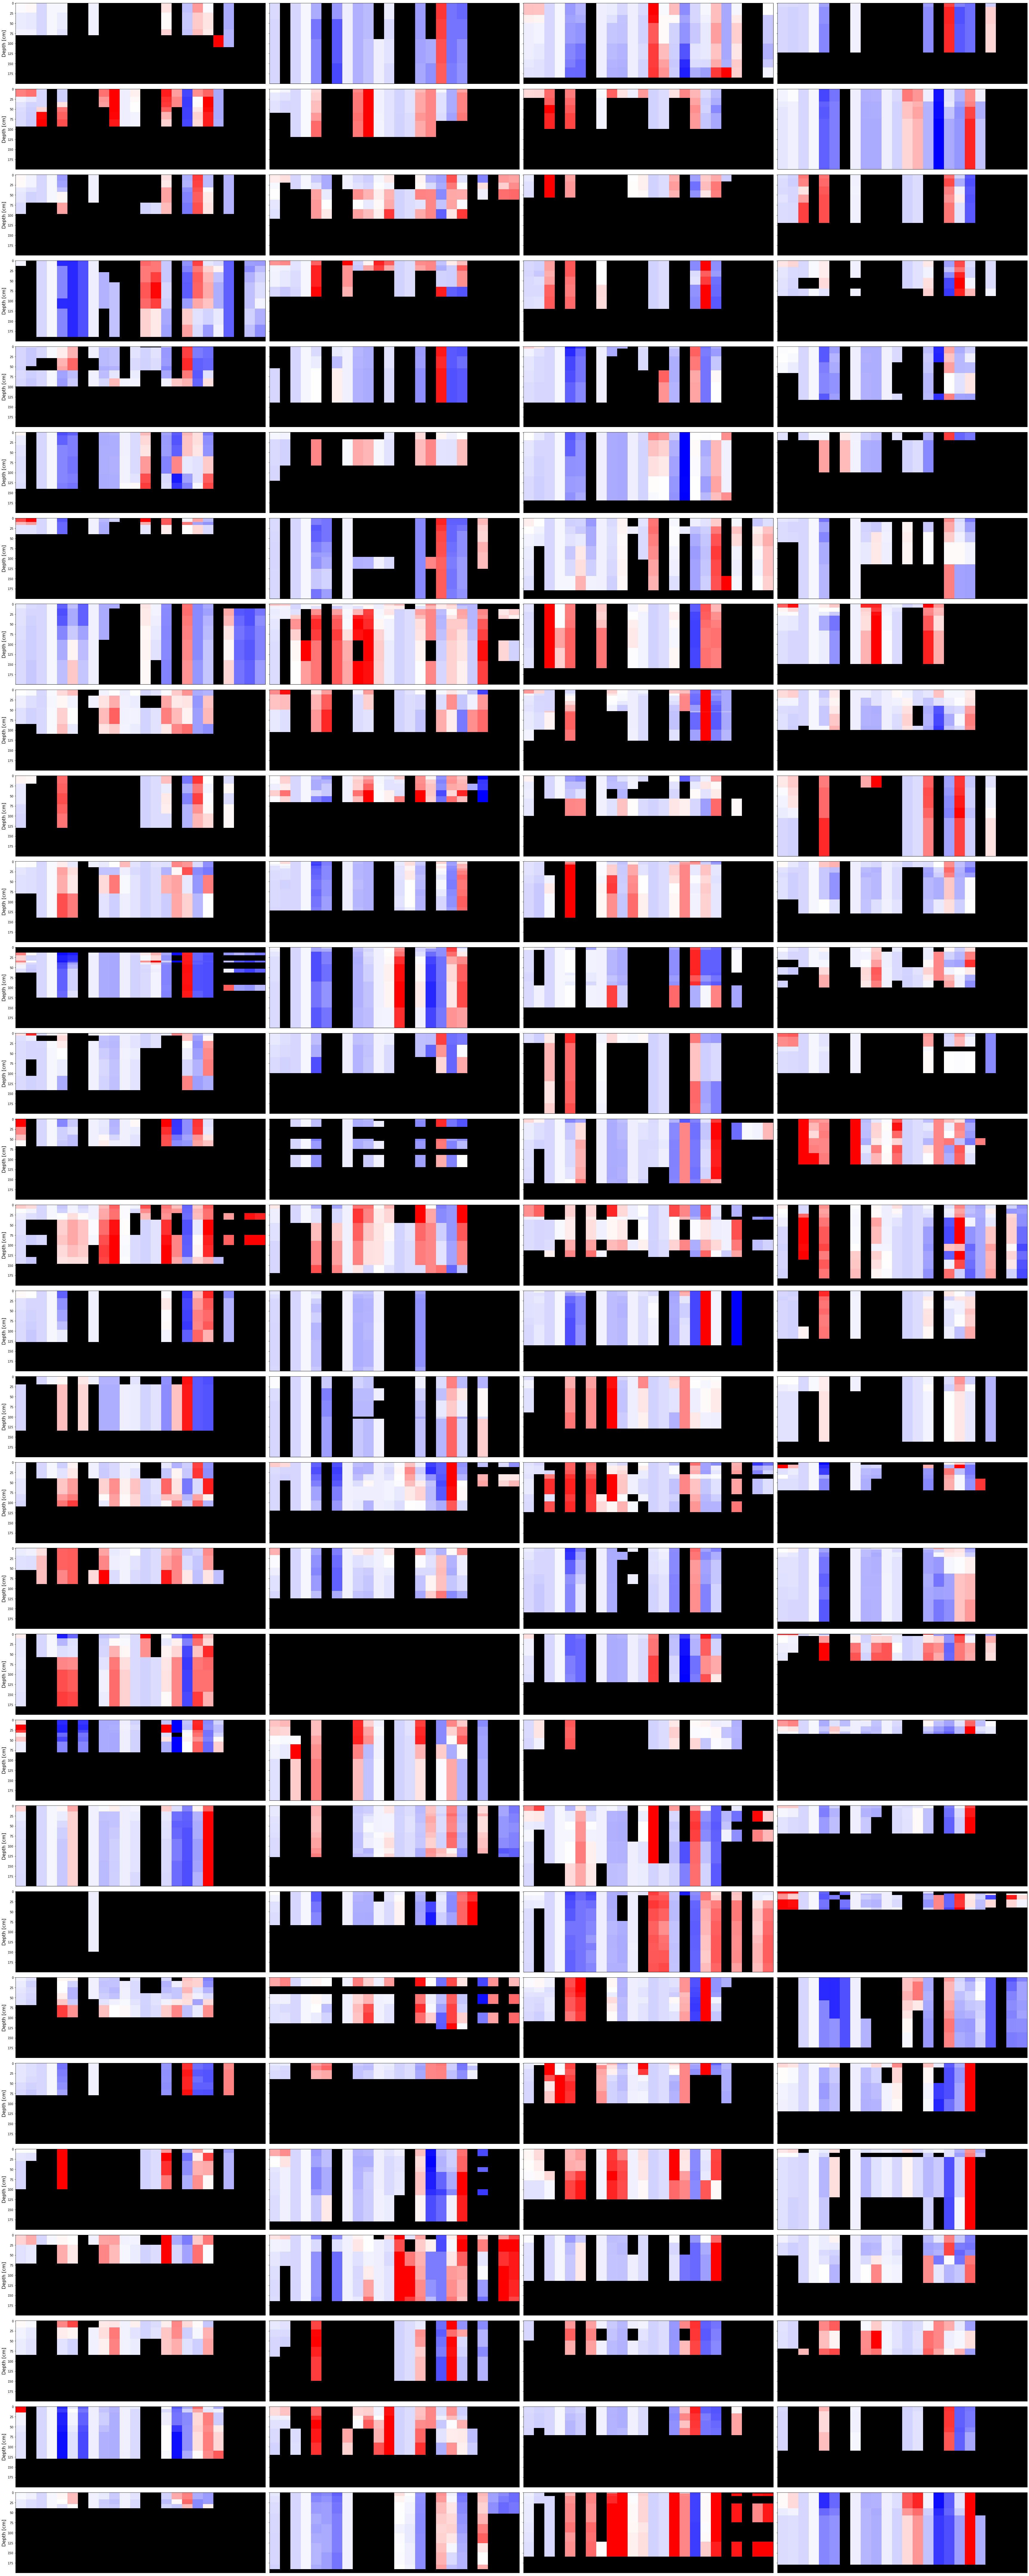

In [ ]:
%%time
# idx_id = 12645
nsites = 120

width, height = 12, 4
ncols = 4

nrows = (nsites - 1) // ncols + 1

fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, sharey=True, 
    figsize=(ncols * width, nrows * height))

axs = axs.flatten()
for i, ax in enumerate(axs):
    is_id = wise3.wise3_id==wise3.wise3_id.sample(1).values[0]

    df_vars_norm = wise3_vars_norm[is_id]

    topdep = wise3.topdep[is_id]
    botdep = wise3.botdep[is_id]
    img = imagify_profile(
        df_vars_norm, botdep, topdep, max_depth=200)

    top_labels = [f'{c.mean():5.2f}{c.std():10.2f}'for _, c in wise3_vars.items()]
    ax = plt_profile_image(
        ax, img, cmap='bwr',) # show_cbar=True,
    #     bot_labels=df_vars_norm.columns, 
    #     top_labels=top_labels)
    if i % ncols != 0:
        ax.set_ylabel(None)
plt.tight_layout()

## Get carbon stock

In [ ]:
path_data = '../data/ISRIC_report_2008_02_csv/'
path_horizon = f'{path_data}/WISE3_HORIZON.csv'

horizon = pd.read_csv(path_horizon)
horizon.columns = [c.lower() for c in horizon.columns]

In [ ]:
horizon.head()

,wise3_id,honu,desig,topdep,botdep,mcolor,dcolor,orgc,totn,caco3,...,cecsoil,bsat,sand,silt,clay,gravel,bulkdens,vmc1,vmc2,vmc3
0,AF0001,1,NaN,0,15,10YR4/3,10YR4/2,7.6,0.6,93.0,...,NaN,NaN,40.0,40.0,20.0,20.0,NaN,NaN,NaN,NaN
1,AF0001,2,NaN,15,60,10YR5/3,10YR5/2,2.3,0.3,177.0,...,NaN,NaN,10.0,55.0,35.0,NaN,NaN,NaN,NaN,NaN
2,AF0001,3,NaN,60,150,10YR5/3,NaN,0.9,0.3,182.0,...,NaN,NaN,10.0,55.0,35.0,NaN,NaN,NaN,NaN,NaN
3,AF0002,1,NaN,0,20,10YR4/2,NaN,12.8,0.9,191.0,...,NaN,NaN,40.0,40.0,20.0,NaN,NaN,NaN,NaN,NaN
4,AF0002,2,NaN,20,60,10YR4/2,NaN,6.0,0.6,192.0,...,NaN,NaN,15.0,65.0,20.0,NaN,NaN,NaN,NaN,NaN


`orgc` = $c$. $[c] =  \frac{g}{kg}.$  
`bulkdens` = $b$. $[b] = \frac{g}{cm^3}.$  
`botdep - topdep` = $l$. $[l] = cm.$  


Depth of interest:
$$
L = 100 \: cm
$$

Method of calculation:
1. Clip off all segments below desired depth.
2. Calculate the carbon volume density of each segment.
3. For each profile, average its segments' carbon volume densities, weighted by segment length.

i.e. for a profile with two segments:
$$
\frac{l_1}{L} c_1 b_1 + \frac{l_2}{L} c_2 b_2 \quad
$$
with units:
$$
\frac{g}{10^{-3} m^{3}} = \frac{kg}{m^{3}} \quad.
$$

In [ ]:
# Depth of interest.
depth = 100 # cm

In [ ]:
# Select organic carbon-related columns.
cols = ['wise3_id', 'topdep', 'botdep', 'orgc', 'bulkdens']
df = horizon[cols].copy()

Get $\frac{l}{L}$.

In [ ]:
# Clip bottoms at desired depth.
# Calculate length of each segment.
# Normalize by depth of interest.
df.loc[:, 'botdep_trunc'] = df['botdep'].clip(upper=depth)
df.loc[:, 'segment_length'] = df['botdep_trunc'] - df['topdep']
df.loc[:, 'segment_length'] /= depth

In [ ]:
# Select needed columns to continue.
df = df[['wise3_id', 'segment_length', 'orgc', 'bulkdens']]

In [ ]:
# Ignore entries with no valid bulkdens, orgc, or segment_length.
df = df[
    df.bulkdens.notnull() & df.orgc.notnull() & df.segment_length.gt(0)
]

Get $\frac{l}{L} c b$.

In [ ]:
df.loc[:, 'weighted_orgc_voldens'] = (
    df['segment_length'] * df['orgc'] * df['bulkdens']
)

In [ ]:
# Average segments weighted by their length for each profile
df = df.groupby('wise3_id').weighted_orgc_voldens.sum()
df = pd.DataFrame(df)
df.rename({'weighted_orgc_voldens': 'carbon_stock'}, axis=1, inplace=True)

Carbon stock.  Units: $\frac{kg}{m^3}$

In [ ]:
df

,carbon_stock
wise3_id,
AL0007,12.11205
AL0008,6.79968
AL0009,10.18997
AL0010,15.78198
AL0011,17.50674
...,...
ZW0060,12.94279
ZW0062,10.39402
ZW0063,11.58268


# Reference

- https://medium.com/@wenyu.z/reading-ms-access-mdb-files-on-mac-969a176baa7a